# Hierarchical Clustering

In [38]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import umap


In [39]:
df = pd.read_csv("./cleaned_dataset.csv")


def get_num_df(df):
    return df.select_dtypes(include=["int64", "float64"])


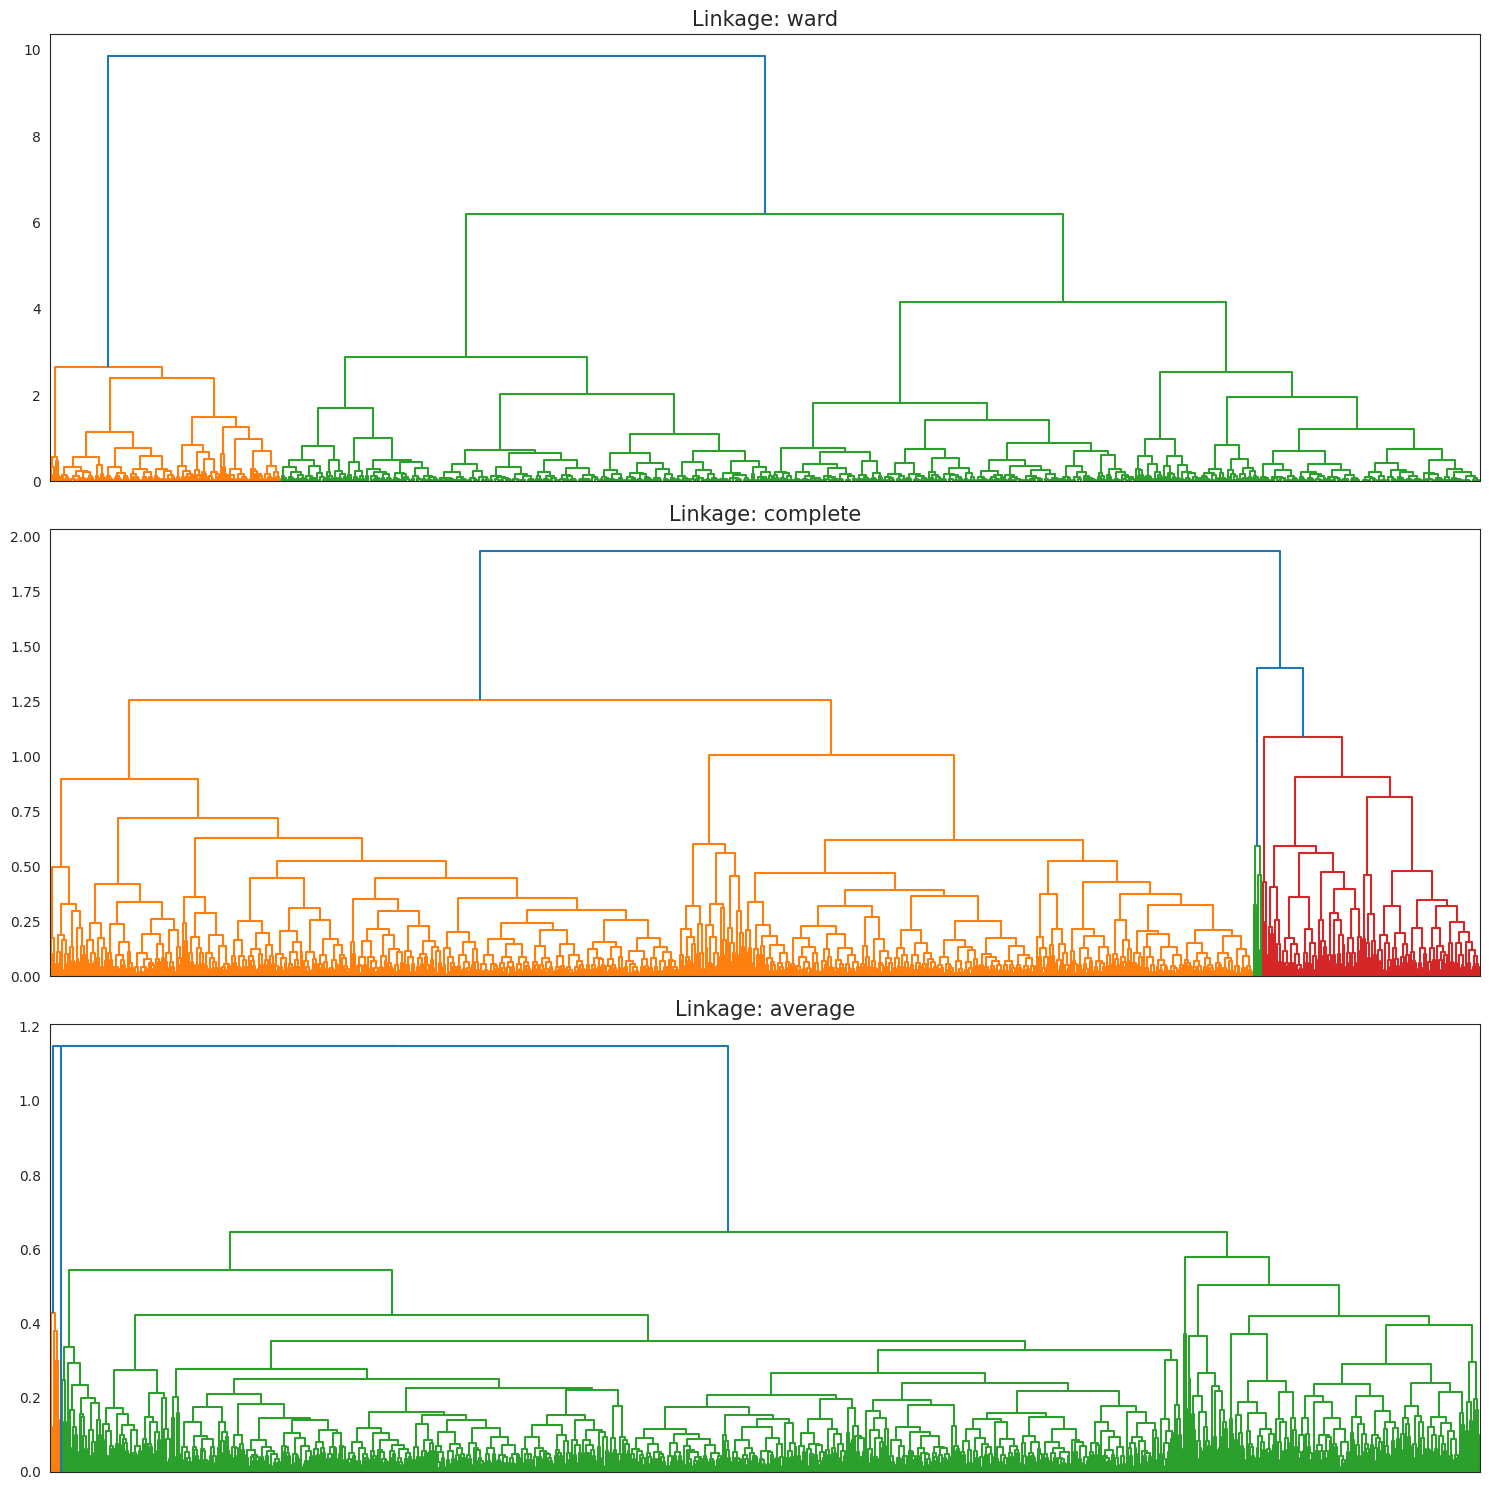

In [40]:
df_num = get_num_df(df)

sns.set_style("white")
fig, axs = plt.subplots(3, figsize=(15, 15))

for lin, row, col in [
    ("ward", 0, 0),
    ("complete", 1, 1),
    ("average", 2, 0),
]:
    Z = linkage(df_num, lin)
    dendrogram(Z, no_labels=True, ax=axs[row])
    axs[row].set_title(f"Linkage: {lin}", fontsize=15)

plt.tight_layout()


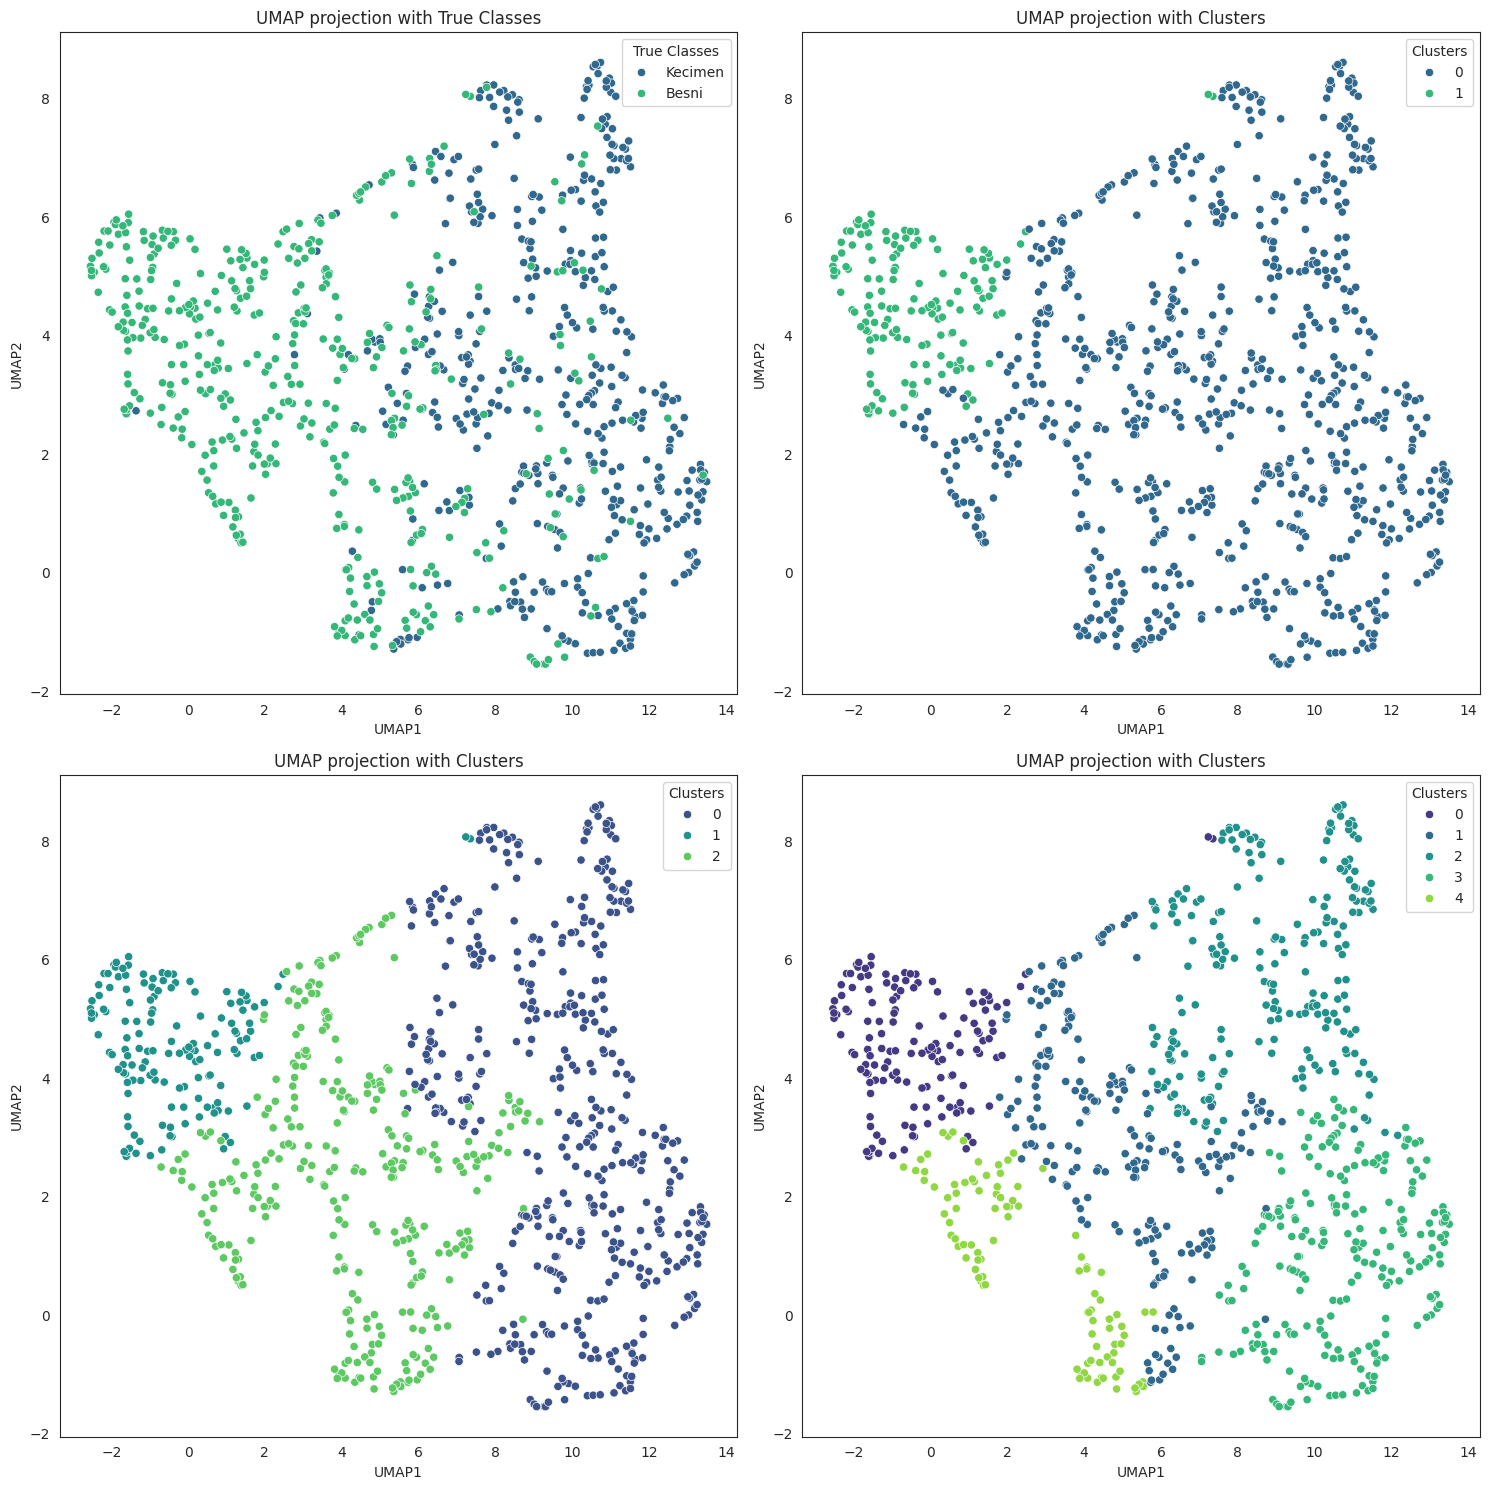

In [41]:
def plot_umap(
    embedding_df, title, ax, hue="Cluster", palette="viridis", n_clusters=None
):
    if n_clusters is not None:
        # If cluster number is provided, adjust the palette
        palette = sns.color_palette(palette, n_colors=n_clusters)
    sns.scatterplot(
        data=embedding_df,
        x="UMAP1",
        y="UMAP2",
        hue=hue,
        palette=palette,
        ax=ax,
        legend="full",
    )
    ax.legend(title=title)
    ax.set_title(f"UMAP projection with {title}")


sns.set_style("white")
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Perform UMAP reduction once, as it should be consistent across different cluster numbers
reducer = umap.UMAP(
    n_neighbors=10, min_dist=0.3, metric="euclidean", random_state=69, n_jobs=1
)
embedding = reducer.fit_transform(df_num)

# Create a DataFrame for the embedding
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
embedding_df["Cluster"] = df["Class"]

plot_umap(embedding_df, "True Classes", axs[0, 0])

results = [embedding_df.copy()]

# Iterate over the specified cluster configurations and plot them
for row, col, n_clusters in [(0, 1, 2), (1, 0, 3), (1, 1, 5)]:
    # Perform hierarchical clustering
    hc = AgglomerativeClustering(
        n_clusters=n_clusters, metric="euclidean", linkage="ward"
    )
    y_hc = hc.fit_predict(df_num)

    # Add the cluster labels to the embedding_df DataFrame
    embedding_df["Cluster"] = y_hc

    results.append(embedding_df.copy())

    plot_umap(
        embedding_df,
        "Clusters",
        axs[row, col],
        hue="Cluster",
        n_clusters=n_clusters,
    )

plt.tight_layout()
plt.show()


In [42]:
for res in results[:3]:
    cluster_names = res["Cluster"].unique()
    for cn in cluster_names:
        print(f"Cluster {cn} out of {len(cluster_names)}")
        # TODO: output as latex table
        print(
            res.loc[res["Cluster"] == cn]
            .drop("Cluster", axis=1)
            .describe()
            .drop("count")
            .rename(
                index={
                    "mean": "Mean",
                    "std": "Std",
                    "min": "Min",
                    "50%": "Med",
                    "25%": "1Q",
                    "75%": "3Q",
                    "max": "Max",
                }
            )
        )
        print("\n")


Cluster Kecimen out of 2
          UMAP1     UMAP2
Mean   9.355232  3.195992
Std    2.415465  2.733166
Min   -1.590565 -1.540947
1Q     7.571801  1.141106
Med    9.801629  2.894134
3Q    11.075140  5.326323
Max   13.503325  8.616141


Cluster Besni out of 2
          UMAP1     UMAP2
Mean   3.224123  3.141059
Std    3.511817  2.160909
Min   -2.540622 -1.543026
1Q     0.465641  1.546363
Med    3.010635  3.451608
3Q     5.691823  4.820572
Max   13.410320  8.195477


Cluster 0 out of 2
          UMAP1     UMAP2
Mean   7.567410  2.899894
Std    3.381097  2.566521
Min   -0.702216 -1.543026
1Q     4.970000  0.987343
Med    7.836909  2.673921
3Q    10.493942  4.722422
Max   13.503325  8.616141


Cluster 1 out of 2
         UMAP1     UMAP2
Mean -0.363343  4.567262
Std   1.547179  1.009079
Min  -2.540622  2.683137
1Q   -1.563532  3.936905
Med  -0.645013  4.527638
3Q    0.681869  5.313838
Max   7.349965  8.075900


Cluster 2 out of 3
         UMAP1     UMAP2
Mean  4.312273  2.284760
Std   2.13493

### Reversed

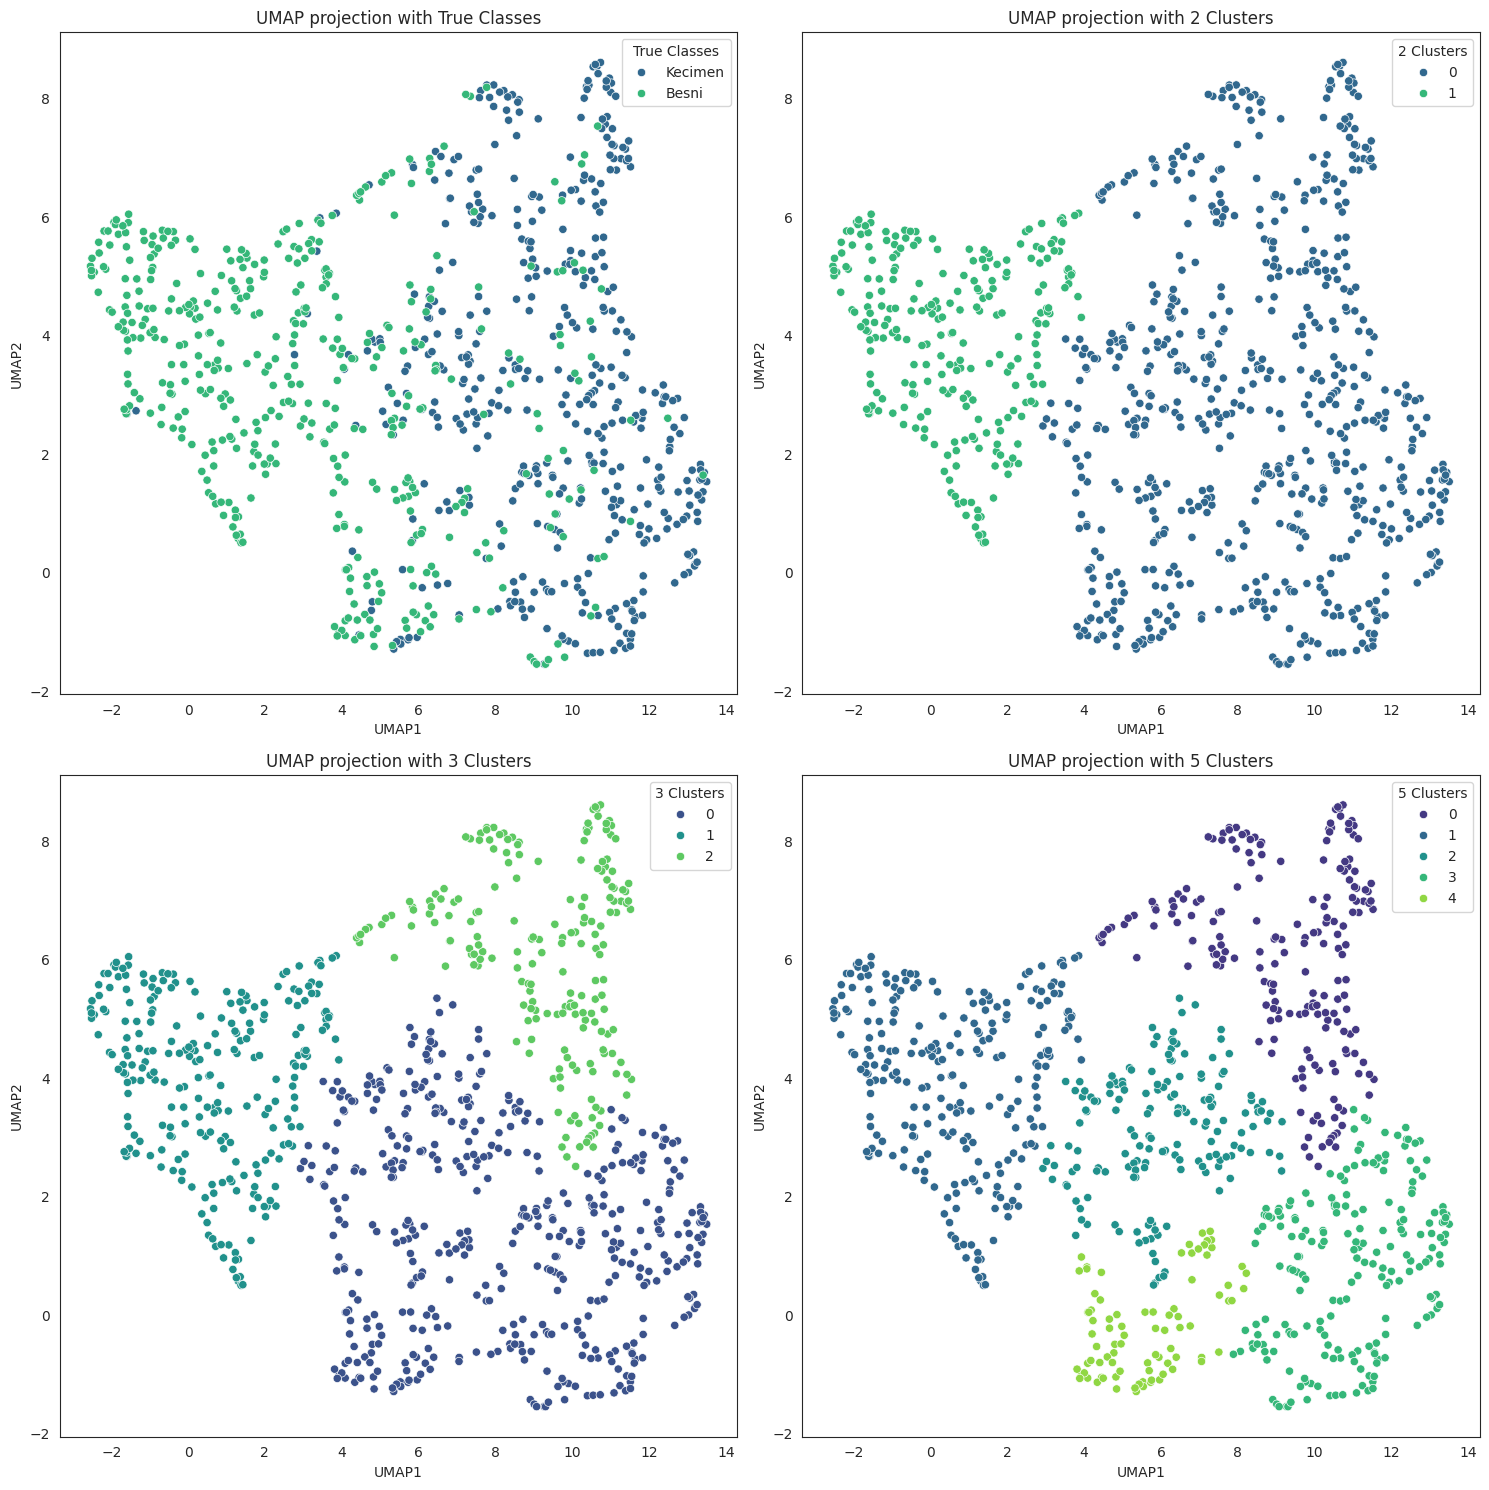

In [44]:
sns.set_style("white")
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

reducer = umap.UMAP(
    n_neighbors=10, min_dist=0.3, metric="euclidean", random_state=69, n_jobs=1
)
embedding = reducer.fit_transform(df_num)

embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])

embedding_df["Cluster"] = df["Class"]
plot_umap(embedding_df, "True Classes", axs[0, 0], hue="Cluster")

for row, col, n_clusters in [(0, 1, 2), (1, 0, 3), (1, 1, 5)]:
    hc = AgglomerativeClustering(
        n_clusters=n_clusters, metric="euclidean", linkage="ward"
    )
    embedding_df["Cluster"] = hc.fit_predict(embedding)

    plot_umap(
        embedding_df,
        f"{n_clusters} Clusters",
        axs[row, col],
        hue="Cluster",
        n_clusters=n_clusters,
    )

plt.tight_layout()
plt.show()
